# **CV2 - Final Project**

**Stav Suzan Rabinovich   208661090**\
**Lior Mitrany  205478258**

## Intro

* How did we get here
* Our inspiration
* Paper sumup (By Stans.)
* What is GAN
* Why use GAN
* What are we going to do in this project

## Import & Notebook Setup

### Imports

In [1]:
import  numpy as np
import  pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import  random
import  glob
import  matplotlib.pyplot as plt
import  os
# import torchmetrics
# import timm
# from    scipy.signal import  convolve2d
from    PIL import Image
import  sys
# from    google.colab.patches  import cv2_imshow

import  cv2
from    cv2 import imread

from    sklearn import svm, datasets
from    sklearn.model_selection import train_test_split
from    sklearn.metrics import confusion_matrix, plot_confusion_matrix

from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

### Setup

In [2]:
!nvidia-smi

Sat Apr 23 17:17:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0    21W /  N/A |      0MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Cuda
* Checks Cuda's availability 
* Checks Cuda's version
* Checks what is the Cuda device

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.version.cuda # check the cuda version

'11.3'

In [5]:
print(f'Device = {torch.cuda.current_device()}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Select the gpu device
torch.cuda.get_device_name(0) # Get the device name
print(device)

Device = 0
cuda


In [6]:
%load_ext autoreload
%autoreload 2

## Data

Here we will write about the birds, the source of the birds, what is the size that will be send next.

#### At first, we will save the images' path.

In [7]:
current_path = !pwd
print(f'Current path = {current_path}')
path_imgs = current_path[0] + '/Birds_Images'
print(f'Path to all images = {path_imgs}')

Current path = ['/mnt/d/ComputerVisionGan']
Path to all images = /mnt/d/ComputerVisionGan/Birds_Images


#### Determine batch size and transposing.

In [8]:
batch_size = 8

epochs = 50

# 64X64 images
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#### Creating the training data and the data loader

In [9]:
train_data = datasets.ImageFolder(path_imgs, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

print(f'The amount of birds classes is: {len(train_loader.dataset.classes)}')
print(f'The name of the class is {train_loader.dataset.classes}')


The amount of birds classes is: 1
The name of the class is ['Birds']


In [10]:
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

## Create the Generator, the Discriminator and predict class.

* Why do I need it ? 
* How do we work with them.

### Generator class

* What is it
* How does it built (and structure)
* What kind of Generator are we using and why?

In [11]:
class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, going into a convolution
        self.conv1 = nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv2 = nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 8 x 8
        
        self.conv3 = nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 16 x 16
        
        self.conv4 = nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats * 2) x 32 x 32
        
        self.conv5 = nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 64 x 64
        
        self.conv6 = nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False)
        # state size. (nchannels) x 64 x 64

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = torch.tanh(self.conv6(x))
        
        return x

### Discriminator

* What is it
* How does it built (and structure)
* What kind of Discriminator are we using and why?

In [12]:
class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()
        # super(self, Discriminator).__init__()

        # input is (nchannels) x 64 x 64
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        # state size. (nfeats) x 32 x 32
        
        self.conv2 = nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 16 x 16
        
        self.conv3 = nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 8 x 8
       
        self.conv4 = nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4
        
        self.conv5 = nn.Conv2d(nfeats * 8, 1, 4, 1, 0, bias=False)
        # state size. 1 x 1 x 1
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        
        return x.view(-1, 1)

## Running the model

### Weights LR 

* Explain of the weights
* What `beta1` refers to
* BCE LOSS: The binary cross-entropy function is a suitable loss function for training the discriminator because it considers a binary classification task.
* Why do we use `criterition` of BCELoss
* Why do we use `Adam Optimizer` and how does it work
* What is `fixed_noise` and why do we use it


* **WHAT DID WE CHANGED FROM THE ORIGINAL ? @mitrlior MAYBE WE SHOULD SHOW FEW RESULTS FROM ORIGINAL AND SOME FROM THE IMPROVED ONE**

In [13]:
# od value 0.0003
lr = 0.0001
# If set beta1 to 0.9 so I can have a better learning rate

weights_path = current_path[0] + '/Weights'

print(f'Device = {device}')

# Binary Cross Entropy
criterion = nn.BCELoss()

nz = 100
fixed_noise = torch.randn(8, nz, 1, 1, device=device)

# old value 0.9
real_label = 0.9

fake_label = 0

batch_size = train_loader.batch_size

print(f'Batch size = {batch_size}')


Device = cuda
Batch size = 8


### Training
In this section, we will explain my misktakes and what I have learnd from them after I was disappointed from my training score we was running for hours.
We started to check online what were wrong in our trainign session so we can get a better resualt on our training.

* The batch Size:\
The biggest mistake that we were doing initially when we started was to use a very big value for batch size.\
While taining a GAN If you are using a very big a Big batch size might hurt the preformance because\
during the initial training the discriminator might get a lot of examples to train on and it might overpover the generator, which could have a negative effect on the training.

* Over traininig:\
All the trainig was running on our local coputer, what it meant is that we could traing the models as long as we want, that was one of our misktakes.
As you can see in this marked code I stopped using, I was allways saving the wieghts from my previous run, when I was loading a new GAN, I was loading those wieghts.\
While training your network you might temped to train your GAN as long as you possibly can, but overtraining might hurt the quality of the generated samples.\
For example, After 200 epochs of that run for 6 hour over night, my modle was showing only black images with a litle color dots.\
Also I could see that the error wasn't stable and from time to time she once were low and at the next epoch she was really high.

* Other optimizers:
Because the article we read about improving the GAN, we started to use more optimizers beside Adam.\
We have seen that we might can get a better score with other optimizers we are using.\

In [14]:
def train(netG, netD, optimizerG, optimizerD, epochs, path):
# Path to the weights
# discriminator_path =  weights_path + '/Discriminator_weights.pth'
# generator_path = weights_path + '/Generator_weights.pth'

# If there are already saved weights, load them to the modles
# if len(os.listdir(weights_path)) != 0:
#     print('Found wighest for the models!\nLoading weights...')
#     netD.load_state_dict(torch.load(discriminator_path))
#     netD.eval()
#     netG.load_state_dict(torch.load(generator_path))
#     netG.eval()
#     print('Weights are loaded to the models.')
# else:
#     print('No weights to load...')
    # print(f'Batch size = {batch_size}')
    if next(netG.parameters()).is_cuda and next(netD.parameters()).is_cuda:
        print('Both models are running on cuda!')
    i = 0
    for epoch in range(epochs):
        nz = 100
        fixed_noise = torch.randn(8, nz, 1, 1, device=device)
        for ii, (real_images, train_labels) in enumerate(train_loader):
            # train with real

            # set the gradients to zero before starting to do backpropragation
            # Clear gradient
            netD.zero_grad()
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            
            labels = torch.full((batch_size, 1), real_label, device=device)

            output = netD(real_images)
            # BCE loss
            errD_real = criterion(output, labels)
            # Calculate the gradient
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            # Generate samples by storing random data 
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            noise = torch.clamp(noise, min=128, max=256)
            # noise = torch.clamp(noise, min=128, max=256)
            # noise = torch.randint(batch_size, low=128, high=256, size=(8, nz, 1, 1))

            fake = netG(noise)
            
            labels.fill_(fake_label)
            # Calculate the output of the discriminator usuing training data
            output = netD(fake.detach())
            # BCE loss
            errD_fake = criterion(output, labels)
            # Calculate gradient
            errD_fake.backward()
            # Mean loss
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake

            # Update discriminator weights
            optimizerD.step()

            # Clear gradient
            netG.zero_grad()

            labels.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake)
            # BCE loss
            errG = criterion(output, labels)
            # Calculate gradient
            errG.backward()
            # Mean loss
            D_G_z2 = output.mean().item()
            # Update generator weights
            optimizerG.step()
            # Save the weights from this round
            # torch.save(netD.state_dict(), discriminator_path)
            # torch.save(netG.state_dict(), generator_path)
        i += 1
        print(f'Epoch: [{i}/{epochs}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x) {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
        # if i % 5 == 0:
        if not os.path.exists(path):
            os.mkdir(path)
        current_path = path + f'/Epocs_{i}'
        saveImages(current_path)
        imgs = load_images_from_folder(current_path)
        show_imgs(imgs)
    



In [15]:
# im_batch_size = 32
n_images=10

saved_image_path = current_path[0] + '/output_images'

if not os.path.exists(saved_image_path):
    os.mkdir(saved_image_path)

def saveImages(saved_image_path):
    if not os.path.exists(saved_image_path):
        os.mkdir(saved_image_path)
    for i in range(n_images):
        gen_z = torch.randn(1, 100, 1, 1, device=device)
        gen_images = netG(gen_z)
        images = gen_images.to("cpu").clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)
        for i_image in range(gen_images.size(0)):
            save_image(gen_images[i_image, :, :, :], os.path.join(saved_image_path, f'image_{i+i_image:03d}.jpg'))

def load_images_from_folder(folder_path):
    imgs = []
    for file_name in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, file_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            imgs.append(img)
    return imgs        

def show_imgs(imgs, columns=10, rows=10):
    display_size = (25, 25)
    fig = plt.figure(figsize=display_size)
    for i, img in enumerate(imgs):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img)
    plt.show()

# imgs = load_images_from_folder(saved_image_path)

# show_imgs(imgs)

Explaining the score:

* D(x) is the critic's output for a real instance.
* G(z) is the generator's output when given noise z.
* D(G(z)) is the critic's output for a fake instance.

# Traing model with Adam optimizer:

Both models are running on cuda!
Epoch: [1/1] Loss_D: 0.3566 Loss_G: 4.1369 D(x) 0.9083 D(G(z)): 0.0117 / 0.0101


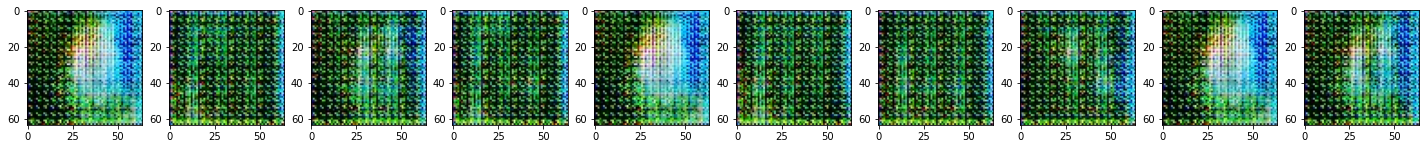

In [16]:
# Defining the models
netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

lr = 0.0003

beta1 = 0.9
beta2 = 0.999

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

path = saved_image_path + f'/{type(optimizerG).__name__}'

train(netG, netD, optimizerG, optimizerD, epochs, path)


# Traing model with AdamW optimizer:

** Expalin Adam vs AdamW**

Both models are running on cuda!
Epoch: [1/1] Loss_D: 0.3797 Loss_G: 5.9011 D(x) 0.8947 D(G(z)): 0.0057 / 0.0014


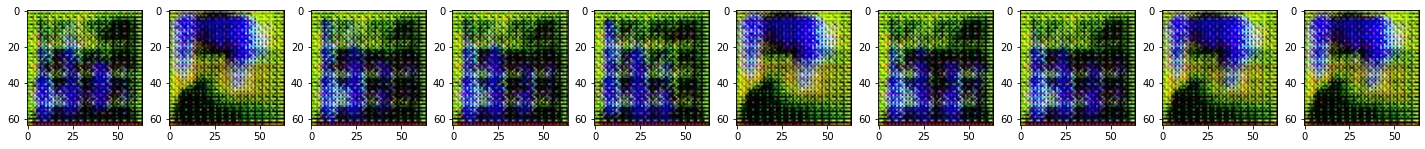

In [17]:
netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

lr = 0.0003

beta1 = 0.9
beta2 = 0.999

optimizerD = optim.AdamW(netD.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=0.5)
optimizerG = optim.AdamW(netG.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=0.5)


path = saved_image_path + f'/{type(optimizerG).__name__}'

train(netG, netD, optimizerG, optimizerD, epochs, path)

# Training model with SGD

Both models are running on cuda!
Epoch: [1/1] Loss_D: 0.3418 Loss_G: 3.9150 D(x) 0.9160 D(G(z)): 0.0149 / 0.0129


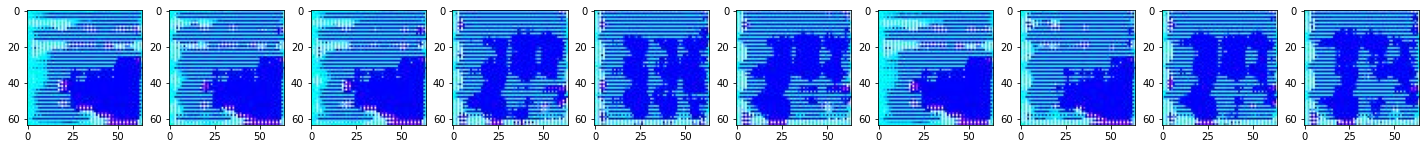

In [18]:
# Defining the models
netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

lr = 0.001

# Defining the optimizers
optimizerD = optim.SGD(netD.parameters(), lr=lr, momentum=0.9)
optimizerG = optim.SGD(netG.parameters(), lr=lr, momentum=0.9)

# Path to the current folder
path = saved_image_path + f'/{type(optimizerG).__name__}'

train(netG, netD, optimizerG, optimizerD, epochs, path)

# Training model with RMSPROP

Both models are running on cuda!
Epoch: [1/1] Loss_D: 0.7085 Loss_G: 3.3645 D(x) 0.7362 D(G(z)): 0.2585 / 0.0239


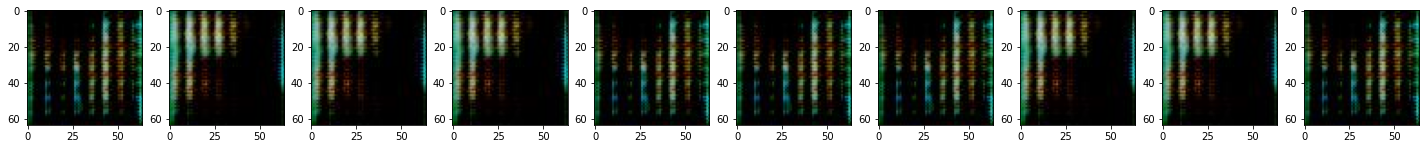

In [19]:
netG = Generator(100, 32, 3).to(device)
netD = Discriminator(3, 48).to(device)

beta1 = 0.9
beta2 = 0.999

lr = 0.0002

optimizerD = optim.RMSprop(netD.parameters(), lr=lr, weight_decay=0.5)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr, weight_decay=0.5)

path = saved_image_path + f'/{type(optimizerG).__name__}'

train(netG, netD, optimizerG, optimizerD, epochs, path)


## Conclusion and Summary

* Did it work? Why ? 
* Copy the idea from previous work.

## Resources

* **Article:** [Regularizing Generative Adversarial Networks Under Limited Data](https://arxiv.org/pdf/2104.03310v1.pdf ) - Hung-Yu Tseng, Lu Jiang, Ce Liu, Ming-Hsuan Yang, Weilong Yang;\
Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 2021, pp. 7921-7931

* [Article](https://medium.com/intel-student-ambassadors/tips-on-training-your-gans-faster-and-achieve-better-results-9200354acaa5) about how to improve our GAN network.

* [Kaggle Notebook](https://www.kaggle.com/code/wendykan/gan-dogs-starter/notebook) about GAN algorithm